# Computational Methods in Economics

## Lecture 8 - Dynamic Programming

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2018-01-17 10:24:24.809799


### Preliminaries

#### Import Modules

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import scipy.optimize

import funapprox_cme as fa
# import sys

# from importlib import reload

## This Lecture

- [Introduction](#intro)
- [Infinite-Horizon Dynamic Optimization in Discrete Time](#theory)
- [The Principle of Optimality and the Bellman Equation](#bellman)
- [Value Function Iteration](#vfi)
- [Numerical Implementation](#ngm)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

## Introduction

Dynamic Programming is a very important tool in many areas in Economics, in particular (but not only) in Macroeconomics for solving intertemporal optimization problems. While I will introduce Dynamic Programming in the context of these types of applications - for example solving variants of the neoclassical growth model - the general idea can be applied to other kinds of optimization problems. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'theory'></a>

## Infinite-Horizon Dynamic Optimization in Discrete Time

The following is based on the exposition in Daron Acemoglu's *Modern Economic Growth*, chapter 6. 

A canonical *discrete-time* *infinite-horizon* dynamic optimization problem can be written as

\begin{equation}
    \max_{\left\{x_t, y_{t}\right\}_{t = 0}^{\infty} }\sum^\infty_{t = 0} \beta^t \tilde{U}(t, x_t, y_t) 
\end{equation}

subject to

\begin{equation}
   y_t \in \tilde{G}(t, x_t), \quad \forall t \ge 0
\end{equation}

\begin{equation}
    x_{t + 1} = \tilde{F}(t, x_t, y_t), \quad \forall t \ge 0
\end{equation}

and $x_0$ given.


Note the following:

- $x_t \in X \subset \mathbb{R}^M$ is referred to as a (vector of) *state variable(s)* in period $t$.

- $y_t \in Y \subset \mathbb{R}^N$ denotes the (vector of) *control variable(s)* in period $t$. It can be chosen from an $N$-dimensional set $Y$ which is given by a *correspondence* $\tilde{G}$ which depends on time and the value of the state variables.

- The function $\tilde{F}$ specifies the evolution of the state variables over time; that is, $\tilde{F}$ gives next period's state variables as a function of the current state vector and control vector. 

- $\tilde{U}$ denotes the *instantaneous payoff* as a function of the current state and control variables, as well as time. The *objective function* is given by 

\begin{equation}
    \sum^\infty_{t = 0} \beta^t \tilde{U}(t, x_t, y_t) 
\end{equation}

where we have already imposed the condition that the objective is a *discounted* sum of instantaneous payoffs, with $\beta$ denoting the discount factor.   

#### Stationarity

In the formulation of the problem above, the functions $\tilde{U}$, $\tilde{F}$, and $\tilde{G}$ all have time $t$ as an explicit argument. If this is not the case, i.e. if we have functions $U$, $F$, and $G$ that do not *explicitly* depend on time, we have a stationary dynamic optimization problem:

\begin{equation}
    \max_{\left\{x_t, y_{t}\right\}_{t = 0}^{\infty} } \sum^\infty_{t = 0} \beta^t U(x_t, y_t) 
\end{equation}

subject to

\begin{equation}
   y_t \in G(x_t), \quad \forall t \ge 0
\end{equation}

\begin{equation}
    x_{t + 1} = F(x_t, y_t), \quad \forall t \ge 0
\end{equation}

and $x_0$ given.

#### Example: NGM

As a concrete example, we can map the abstract stationary problem above to the familiar neoclassical growth model that we have already seen multiple times. As a reminder, here is a concise description of the model: 

- Utility function:

\begin{equation}
    u(c, h) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h^{1+\eta}}{1+\eta}
\end{equation}

with $c$ denoting consumption and $h$ labor supply.

- Production function:

\begin{equation}
    f(k_t, h_t) = A k_t^\alpha h_t^{1-\alpha}
\end{equation}

with $k$ denoting the capital stock, and $A$ the productivity level.

- Resource Constraint:

\begin{equation}
    k_{t+1} + c_t = f(k_t, h_t) + (1 - \delta) k_t = A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t
\end{equation}

- Planner's Problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_t\right\}_{t = 0}^{\infty} } \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}
s.t. the resource constraint.

Using the constraint to substitute for $c_t$, the problem can be written as

\begin{equation}
    \max_{\left\{k_t, k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(f(k_t, h_t) + (1 - \delta) k_t - k_{t+1}, h_t) 
\end{equation}

with $k_0$ given. 

Mapping this problem to the general formulation above, we see the following:

- There is one state variable, $x_t = k_t$.

- The vector of choice variables is given by $y_t = (k_{t + 1}, h_t)$.

- Instantaneous payoff is given by the per-period utility function $U\big(k_t, (k_{t + 1}, h_t)\big)  = u(f(k_t, h_t) + (1 - \delta) k_t - k_{t+1}, h_t)$

- The function $F$ is essentially an identity function $x_{t + 1} = k_{t + 1} = F\big(k_t, (k_{t + 1}, h_t)\big) = k_{t + 1}$. 

- What is the choice set for the control variables? For $h_t$, there is no constraint other than that it cannot be negative, and hence $h_t \in [0, \infty)$. For $k_{t+1}$, we also have $k_{t+1} \ge 0$. In addition, it is bounded above by $f(k_t, h_t) + (1 - \delta)$, since otherwise consumption would be negative. Hence,

\begin{equation}
    k_{t+1} \in [0, f(k_t, h_t) + (1 - \delta) k_t)
\end{equation}

Note that this problem is stationary since the per-period utility function and the production function do not depend directly on time (of course, their arguments do depend on time $t$). Note that this would not be the case if the productivity level $A$ in the production function would change with time rather than being constant. If $A_t$ were to grow with a constant rate $g$, i.e.

\begin{equation}
    A_t = (1 + g) A_{t-1} = (1 + g)^t A_0,
\end{equation}

we could make the model stationary by transforming the variables - more on that in the problem set!

#### Sequential Problem

Going back to the canonical stationary problem above,

\begin{equation}
    \max_{\left\{x_t, y_{t}\right\}_{t = 0}^{\infty} } \sum^\infty_{t = 0} \beta^t U(x_t, y_t)
\end{equation}
s.t.
\begin{equation}
    y_t \in G(x_t), \quad x_{t + 1} = F(x_t, y_t), \quad \forall t \ge 0, \quad \text{and}\ x_0\ \text{given},
\end{equation}

we are looking for the sequences $\{x^*_t, y^*_t\}_{t = 0}^\infty$ that attain the maximal value of the problem. We refer to these *infinite* sequences as a solution to the intertemporal optimization problem or an *optimal plan*. Our objective when solving any intertemporal optimization problem is usually to characterize this optimal plan (in practice, up to some finite period $T$).

Note that we have solved such a *sequential* or *sequence* problem previously in the lecture on numerical optimization, in the context of the NGM. We have made an optimization algorithm (BFGS) choose a sequence (i.e. a vector) of values for capital and labor up to period $T$ and then made use of the fact that the problem converged to steady state.   

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'bellman'></a>

## The Principle of Optimality and the Bellman Equation

#### Value Function

For the generic stationary problem above, let's define the *value function* 

\begin{equation}
    V^*: X \rightarrow \mathbb{R}
\end{equation}

as highest possible value (i.e. the maximum) that the objective function can reach, given the initial $x_0$. Hence,

\begin{equation}
    V^*(x_0) = \max_{\left\{x_t, y_{t}\right\}} \sum^\infty_{t = 0} \beta^t U(x_t, y_t)\quad \text{s.t.}\quad y_t \in G(x_t), \quad x_{t + 1} = F(x_t, y_t), \quad \forall t \ge 0
\end{equation}

With the optimal plan $\{x^*_t, y^*_t\}_{t = 0}^\infty$, we can also write the value function as 

\begin{equation}
    V^*(x_0)  = \sum^\infty_{t = 0} \beta^t U(x^*_t, y^*_t) 
\end{equation}


#### Principle of Optimality

Noting that the optimal state in the first period is constrained by the initial state, $x^*_0 = x_0$, the last expression can be rewritten as:

\begin{equation}
\begin{split}
    V^*(x_0)  &= \sum^\infty_{t = 0} \beta^t U(x^*_t, y^*_t) \\
              &= U(x^*_0, y^*_0) + \sum^\infty_{t = 1} \beta^t U(x^*_t, y^*_t) \\
              &= U(x_0, y^*_0) + \beta \sum^\infty_{t = 0} \beta^t U(x^*_{t+1}, y^*_{t+1}) 
              &= U(x_0, y^*_0) + \beta V^*(x^*_{t+1}) 
\end{split}
\end{equation}

This equation encapsulates the basic idea of dynamic programming: an optimal plan can be broken into two parts, the *current return* (i.e what is optimal today) and the *continuation return*. This is called the *Principle of Optimality*. 

Above we have stated the principle of optimality for the initial period. For a more general version, define the *set of feasible plans* as all plans that satisfy the constraints of the optimization problem when starting at an arbitrary state $x_t$:

\begin{equation}
    \Phi(x_t) = \big\{ \{x_s, y_s\}_{s = t}^\infty: y_s \in G(x_s), \ x_{s + 1} = F(x_s, y_s) \quad \text{for}\ s = t, t+1, ... \big\}
\end{equation}

Moreover, make the following assumption:

**Assumption**: $G(x)$ is non-empty for all $x \in X$. Moreover, for all $x(0) \in X$ and $\{x_t, y_t\}_{t = 0}^\infty \in \Phi(x_0)$, $\lim_{n \rightarrow \infty} \sum^n_{t = 0} \beta^t U(x_t, y_t)$ exists and is finite.

In words, for any state, there is a feasible policy $y$. Moreover, in the limit, the discounted sum of per-period utilities does not converge to infinity.


We then have the following theorem.

**Theorem (Principle of Optimality)**: Suppose the assumption above holds. Let $\{x^*_t, y^*_t\}_{t = 0}^\infty \in \Phi(x_0)$ be a feasible plan that attains $V^*(x_0)$ in the sequential problem above.  Then, 

\begin{equation}
   V^*(x^*_t) = U(x^*_t, y^*_t) + \beta V^*\big(F(x^*_{t}, y^*_t)\big) 
\end{equation}

for $t = 0, 1, ...$, with $x^*_0 = x_0$. Moreover, if any $\{x^*_t, y^*_t\}_{t = 0}^\infty \in \Phi(x_0)$ satisfies this equation, then it attains the $V^*(x_0)$ in the sequential problem above.

In other words, this theorem says that any feasible plan that is a solution to the sequential problem above, also satisfies a *recursive* formulation of the problem. 

#### The Bellman Equation 

The Bellman equation is at the center of dynamic programming. It can be written in the following way:

\begin{equation}
    V(x)  =  \max_{ y \in G(x) }  U(x, y) + \beta V(x^+), \quad \forall x \in X
\end{equation}

s.t. $x^+ = F(x, y)$.

Before looking at why this is useful, a few features are worth noting:

- The Bellman equation is a *functional equation*: instead of finding a scalar or vector that satisfies it, we will solve it by finding an ex-ante unknown function $V$ which appears on both the left- and the right-hand side. This is also why the Bellman equation is called a *recursive formulation* of the intertemporal optimization problem. 

- Related to this, note that this functional equation must be satisfied for *all* state variables $x$ that are admissible (i.e. lie in the set $X$) 

- On the right-hand side, rather than choosing an optimal plan $\{x^*_t, y^*_t\}_{t = 0}^\infty \in \Phi(x_0)$ explicitly, we choose the *policy* $y$ only for one period, which is a scalar or vector depending on the dimension of the control vector, given this period's state $x$. Note that in a stationary problem, since the instantaneous payoff function does not depend on time, a policy is not time dependent either. That's why we have omitted time subscripts here.

Why is the Bellman equation useful for solving an intertemporal optimization problem? There are essentially three parts to answering this question:

- First, we are going to show that the recursive formulation above is equivalent to the sequential problem, in the sense that any optimal plan $\{x^*_t, y^*_t\}_{t = 0}^\infty \in \Phi(x_0)$ that solves the sequential problem also satisfies the Bellman equation.

- Second, if we know the value function $V$, we can easily find an optimal plan by repeatedly solving the low-dimensional problem on the right-hand side of the Bellman equation.

- Third, since the value function is ex-ante unknown, we need to solve the Bellman equation for $V$. While functional equations can be tricky to work with in general, it turns out that the Bellman equation is computationally very convenient, and there are efficient algorithms to find $V$. As a result, dynamic optimization problems can be much easier to solve using the Bellman equation than a sequential formulation (and in some cases, it is the only option).

With respect to the Bellman equation being equivalent to the sequential problem, we need the following theorem.

**Theorem (Equivalence of Values)**: Suppose the assumption above holds. Then for any $x \in X$, any solution $V^*(x)$ to the sequential problem is also a solution to the Bellman equation

\begin{equation}
    V(x)  =  \max_{ y \in G(x) }  U(x, y) + \beta V\big(F(x, y)\big), \quad \forall x \in X
\end{equation}

Moreover, any solution $V(x)$ to the Bellman equation is also a solution to the sequential problem, so that $V^*(x) = V(x)$ for all $x \in X$. 

This theorem establishes that the value functions defined by the sequential and the recursive formulation of the problem are equivalent. However, we are ultimately interested in equivalence with respect to the solutions. Recall that by the principle of optimality, any feasible solution $\{x^*_t, y^*_t\}_{t = 0}^\infty$ to the sequential problem satisfies 

\begin{equation}
   V^*(x^*_t) = U(x^*_t, y^*_t) + \beta V^*\big(F(x^*_{t}, y^*_t)\big). 
\end{equation}

Since we have just shown that $V^*(x) = V(x)$ for all $x \in X$, we can write this as

\begin{equation}
   V(x^*_t) = U(x^*_t, y^*_t) + \beta V\big(F(x^*_{t}, y^*_t)\big). 
\end{equation}

Moreover, consider a feasible sequence $\{\hat{x}_t, \hat{y}_t\}_{t = 0}^\infty \in \Phi(x_0)$ that satisfies the Bellman equation *for a given value function* $V$. That is, for any period $t$, $\hat{y}_t$ is the solution to the right hand side for the Bellman equation given the state $\hat{x}_t$. Hence, for all $t = 0, 1, ...$, we have 

\begin{equation}
    V(\hat{x}_t)  =  U(\hat{x}_t, \hat{y}_t) + \beta V\big(F(\hat{x}_t, \hat{y}_t)\big).
\end{equation}

Comparing the last two expressions, we see that $\{x^*_t, y^*_t\}_{t = 0}^\infty$ satisfies the Bellman equation, and hence any solution to the sequential problem is also a solution to the recursive formulation of the problem.

Why is this result useful? Recall that we are interested in the optimal plan $(x^*_t, y^*_t)_{t = 0}^\infty$. Suppose we know the functional form of the value function $V$. Since we have just established that any optimal plan satisfies the Bellman equation, we can use its right-hand side to solve for the optimal $(x^*_{1}, y^*_1)$ given some initial state $x_{0}$. Then, we can use $x^*_{1}$ as the initial state and solve for $(x^*_{2}, y^*_2)$ and so on. 

In other words, by solving the RHS of the Bellman equation repeatedly and updating the state vector for every period, we can *generate* the sequences $\{x^*_t, y^*_t\}_{t = 0}^T$ up to some arbitrary period $T$ (which can be very large). We will refer to this as "simulating" the model, as discussed below. 

In this way, rather than computing the optimal plan explicitly in one large optimization problem, we compute it recursively solving a *small-scale optimization problem in every period*. This is not only more computationally efficient in many cases, it sometimes may also be the only way to find the optimal plan, for example under uncertainty.

Of course, a prerequisite for this strategy is knowing the value function $V$. We turn to how do this in the next section. 

As final remark, note that another advantage of solving an intertemporal optimization problem using stationary dynamic programming is that the solution can be represented by a time-invariante *policy function* $\phi: X \rightarrow Y$. In other words, $\phi(x)$ gives the optimal value to choose for a given value of the state variable $x$.

For a given value function $V$, the policy function is defined implicitly by

\begin{equation}
    V(x)  =  U(x, \phi(x)) + \beta V\big(F(x, \phi(x))\big)\quad \forall x \in X.
\end{equation}

This equation simply follows from the fact that $\phi(x)$ is the optimal policy, so when $y = \phi(x)$, the RHS of the Bellman eqution reaches the optimal value $V(x)$. As before, the intuition for $\phi$ not depending on time is that the instantaneous payoff function does not depend on time in a stationary problem.

We will see below how to find the policy function(s) numerically and how to use them to find the optimal plan.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'vfi'></a>

## Value Function Iteration

The next question is how to find the value function $V$, starting from the Bellman equation:

\begin{equation}
    V(x)  =  \max_{ y \in G(x) }  U(x, y) + \beta V(x^+)
\end{equation}

s.t. $x^+ = F(x, y)$. 

Before moving on, note that the Bellman equation is often expressed as 

\begin{equation}
    V  = \mathcal{T}V
\end{equation}

$\mathcal{T}$ is a mapping (also referred to as an "operator") which is applied on a function. Recall that a function is a mapping in a (finite-dimensional) Euclidean space that maps a scalar/vector $x$ to a scalar/vector $y$. Similarly, an operator is a mapping in an infinite-dimensional *metric* space that maps a function $w$ to a function $z$. 

The Bellman equation then implies that $\mathcal{T}$ maps $V$ onto itself. In other words, $V$ is a fixed point of $\mathcal{T}$.

It turns out that in order to find this fixed point, we can use an iterative procedure, an idea that we have already encountered in previous lectures. As a reminder, the basic idea of iterative methods is to generate a sequence of approximations to the object of interest, here the value function, i.e. to generate $\left\{ V^{(k)} \right\}_{k = 0}^\infty$. These approximations should converge, i.e. become more and more "precise" with an increasing number of iterations. 

\begin{equation}
    V^{(k)} \ \rightarrow\ V \quad \text{as} \quad k\ \rightarrow\ \infty. 
\end{equation}

When we talked about iterative methods in previous lectures, the object of interest was a scalar or a vector, i.e. a finite-dimensional object. Here, we aim to approximate an infinite-dimensional function. 

The iteration rule is 

\begin{equation}
    V^{(k+1)} = \mathcal{T} V^{(k)}. 
\end{equation}

In other words, we take the current guess $V^{(k)}$ and use it to solve the RHS side of the Bellman equation. The resulting value function is used as the new guess $V^{(k+1)}$:

\begin{equation}
    V^{(k+1)}(x)  =  \max_{ y \in G(x) }  U(x, y) + \beta V^{(k)}\big(F(x, y)\big)
\end{equation}

In the next lecture, we will see under which conditions the sequence $\left\{ V^{(k)} \right\}$ generated in this way converges to the true value function. For now, we take this convergence as given, and discuss how to implement *value function iteration* numerically.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'NGM'></a>

## Numerical Implementation

As mentioned above, a function is an infinite-dimensional object, hence we have to find a way to represent it on the computer with a finite-dimensional object. Fortunately, we have already encountered a way to do this in the context of function approximation: recall that the approximant $\hat{f}$ to a function $f$ is a linear combination of (a finite number of) basis functions, with (a finite number of) basis coefficients. 

Hence, when numerically implementing value function iteration, the value function will be represented by a vector of basis coefficients (and a given set of basis functions), which will be updated in every iteration. Formally,

\begin{equation}
   V^{(k)}(x) \approx \hat{V}(x; a^{(k)}) = \sum_{j = 0}^{n} a^{(k)}_j B_j(x)
\end{equation}

This leads to the following pseudo-code:

(i) Choose the approximation grid $\{x_i : 1 \le i \le m\} \subset \mathbb{R}^M$. Moreover, choose a degree of approximation $n$ and a family of basis functions $\{B_j(x) : 0 \le j \le n\}$.

(ii) Choose an initial value for the basis coefficients $\{a_j : 0 \le j \le n\}$, denoted by $a_j^{(0)}$. The initial guess for the value function $V$ is approximated by 

\begin{equation}
    \hat{V}^{(0)} = \hat{V}(x; a^{(0)}) = \sum_{j = 0}^{n} a^{(0)}_j B_j(x)
\end{equation}

(iii) *Optimization step*: for a given vector $a^{(k)}$, compute 

\begin{equation}
\begin{split}
    v_i &= \max_{ y \in G(x_i) }  U(x_i, y) + \beta \hat{V}^{(k)}\big(F(x_i, y)\big) \\
        &=  \max_{ y \in G(x_i) }  U(x_i, y) + \beta \sum_{j = 0}^{n} a^{(k)}_j B_j\big(F(x_i, y)\big)
\end{split}
\end{equation}

for each approximation node $x_i$.

(iv) *Fitting step*: given the data $(x_i, v_i:  1 \le i \le m\}$, use an appropriate approximation method to find $a^{(k+1)}$ such that

\begin{equation}
    \hat{V}(x_i; a^{(k + 1)}) \approx v_i 
\end{equation}

Note that this last expression would feature an equality in the case of interpolation.

(v) *Stopping rule*: compute the convergence criterion $\epsilon$ which compares the new guess $a^{(k + 1)}$ with the current guess $a^{(k)}$, i.e. is a function of these two vectors. If the convergence criterion is less than some small number, e.g. the square root of machine epsilon,

\begin{equation}
    \epsilon(a^{(k)}, a^{(k + 1)}) \le \sqrt{\epsilon_{DP}}
\end{equation}

then stop and report $a^{(k + 1)}$. Otherwise, go back to (iii).

Before moving to the actual Python implementation, note that each iteration features two essential operations: optimization and function approximation. For both of them, we have learned efficient and reliable methods earlier in this course. Below, we will use the BFGS method for the optimization problem in the Bellman equation, and Chebyshev polynomials and nodes to approximate the value function. 

#### Workhorse Example: NGM

We now use this algorithm to solve the NGM, as outlined above. From the mapping between the NGM and the general intertemporal optimization problem outlined above, we can write the Bellman equation for the NGM as:

\begin{equation}
    V(k_t)  =  \max_{ h_t \in [0, \infty), \ k_{t+1} \in [0, f(k_t, h_t) + (1 - \delta) k_t) }  u(f(k_t, h_t) + (1 - \delta) k_t - k_{t+1}, h_t) + \beta V(k_{t+1})
\end{equation}


We start by defining the parameters and computing the steady state, as seen before:

In [4]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
eps = 1e-6      # lower bound of consumption and labor supply
## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)      # parameter for utility function
## initial capital stock
k0 = 0.8

In [5]:
def cd(x, alpha, A):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * x[1]**(1 - alpha)

def cd_diff(x, alpha, A):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (alpha * cd(x, alpha, A) / x[0], (1 - alpha) * cd(x, alpha, A) / x[1])

def steady(x):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(2)
    mp = cd_diff(x, alpha, A)
    
    y[0] = beta * (mp[0] + 1 - delta) - 1
    y[1] = (cd(x, alpha, A) - delta * x[0])**(-nu) * mp[1] - B * x[1]**eta
    
    return y

## solve for steady state
x0 = np.array([0.5, 0.5])
res = scipy.optimize.root(steady, x0,  tol = 1e-8, method = "broyden1")
kss, hss = res.x 
print(kss, hss)


1.0 1.0


#### Interpolation grid and initial guess

We can now implement the steps in the VFI algorithm. For the interpolation grid, we set $m = 10$. For the end points, note that since our initial capital stock is $k_0 = 0.8$ and its steady state value 1, we can focus on values for $k_t$ between $0.7$ and $1.3$. 

In [6]:
m = 10
k_min = 0.7
k_max = 1.3

k_grid = fa.chebgrid(k_min, k_max, m)

We use an interpolation scheme, and hence $n = m - 1$. As an initial guess for the basis coefficients, $a^{(0)}$, a common choice is start with a vector of zeros; note that this would imply that the initial guess for the approximated continuation function, $\hat{V}^{(0)}$, is zero. 

However, this may not be the best choice: for more computationally intensive problems, we want our initial guess to be as close to the true value function as possible, in order to minimize the number of iterations and hence the running time of the algorithm above. Moreover, in the NGM, note that if the continuation value on the RHS of the Bellman equation is zero, this also implies that the control variable $k_{t+1}$ is set to zero for all state variables; intuitively, there is no reason to build up capital for the next period if it doesn't give you any utility. $k_{t+1} = 0$ would imply a capital stock outside of our grid, which causes problems when approximating the continuation value.

For a better initial guess, consider the special case of the NGM with logarithmic utility and full capital depreciation. We know that in this case, consumption and savings are a fixed share of output in every period. We can derive the value function in this case as

\begin{equation}
    V(k) = \frac{\alpha}{1 - \alpha \beta} \log(k) + Q
\end{equation}

where $Q$ is a constant depending on the model parameters. We can use the first term as an initial guess for our value function in the more general case:

In [7]:
## set the degree of approximation
n = m - 1

## initial guess for VF
V0 = (alpha / (1 - alpha * beta)) * np.log(k_grid )
## compute implied basis coefficients
a0 = fa.chebapprox(V0, n)

#### Optimization Step

For the optimization step (iii) in the VFI algorithm, it is useful to define a function that contains the objective function of the optimization problem on the right hand side of the Bellman equation.

In [8]:
def f(k, h):
    """
    Production function
    """
    return A * k**alpha * h**(1 - alpha)

def u(c, h):
    """
    Utility function
    """
    return c**(1 - nu)/(1 - nu) - B * h**(1 + eta)/(1 + eta)


def vf_rhs(x, k, a, k_min, k_max):
    """
    RHS of the Bellman equation
    """
    kp = np.exp(x[:int(len(x)/2)])
    h = np.exp(x[int(len(x)/2)])

    return (- u(f(k, h) + (1 - delta) * k - kp, h) 
            - beta * np.polynomial.chebyshev.chebval(fa.chebconvert(kp, k_min, k_max), a) )

We can use Scipy's **minimize** function with the BFGS method to solve the problem on the RHS of the Bellman equation. Recall that we need to run a separate optimization for each of the $m$ grid point, which correspond to different initial capital stocks. We can use a **for** loop that iterates over **k_grid**:  

In [9]:
x0 = (0, 0)
V = np.zeros(m) 
for (ind, k) in enumerate(k_grid):
    ## optimization step
    res = scipy.optimize.minimize(vf_rhs, x0, args = (k, a0, k_min, k_max), method ='BFGS') 
    V[ind] = - res.fun
    print(res.message)

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.


In order to better structure our code below, it is useful to implement the steps above as a Python function, here called **opt_step**:

In [10]:
def opt_step(k_grid, obj_fun, x0, a_ch, k_min, k_max):     
    """
    Function that loops over all states (= elements in k_grid) and solves the respective optimization problem (obj_fun, initial guess x0)
    for a given vector of Chebyshev basis coefficients a_ch
    -> uses Scipy's optimize module
    """
    ## initialize policy and value functions
    V = np.zeros(m)
    K = np.zeros(m)
    H = np.zeros(m)
    
    ## loop
    for (ind, k) in enumerate(k_grid):
    ## optimization step
        res = scipy.optimize.minimize(obj_fun, x0, args = (k, a_ch, k_min, k_max), method ='BFGS') 
        V[ind] = - res.fun
        K[ind], H[ind] = np.exp( res.x )

    return V, K, H

#### Fitting Step

The optimization step returns the "new" value function $v_i$ - given the continuation value $\beta \hat{V}^{(k)}$ computed with the current guess $a^{(k)}$ - for each of the $m$ grid points $k_i$. Since **k_grid** was defined as a Chebyshev grid and the continuation value was approximated with a Chebyshev basis, we can use our **chebapprox** function on the data $\{k_i, v_i:  1 \le i \le m\}$ to find the "new" guess $a^{(k + 1})$.

In [11]:
a = fa.chebapprox(V, n)

#### Outer Loop

As outlined in the algorithm above, we iterate on the optimization and on the fitting step until

\begin{equation}
    \epsilon(a^{(k)}, a^{(k + 1)}) \le \sqrt{\epsilon_{DP}}
\end{equation}

where $\epsilon$ denotes the convergence criterion as a function of the new and current iterates for the basis coefficients. What is a suitable functional form for $\epsilon$? The easiest approach would be to compute the norm of the distance between $a^{(k)}$ and  $a^{(k + 1)}$:

\begin{equation}
    \epsilon(a^{(k)}, a^{(k + 1)}) = \left|\ a^{(k)} - a^{(k + 1)}\ \right|
\end{equation}


As in the other instances of iterative procedures that we have seen in previous lectures, we can use a **while** loop to iterate until the convergence criterion is sufficiently small. 

In [12]:
## initialize initial guess for basis coefficients and optimization
a_ch = a0.copy()
x0 = (0, 0)

eps = 1
it = 0
maxit = 100

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, H = opt_step(k_grid, vf_rhs, x0, a_ch, k_min, k_max)
    ## fitting step
    a_new = fa.chebapprox(V, n)
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()

print(it, eps)

85 8.01877942696e-09


The following piece of code repeats this last step, while plotting the approximated value function for every iteration. The graph illustrates convergence, in the sense that the distance between two iterates of value function decreases in the number of iterations.

In [13]:
a_ch = a0.copy()
eps = 1
it = 0
maxit = 100

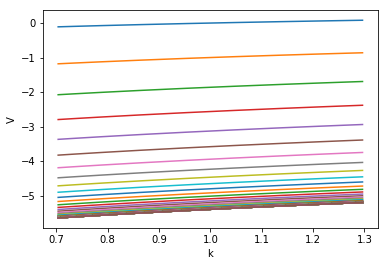

In [14]:
fig, ax = plt.subplots()
ax.plot(k_grid, V0)
ax.set_xlabel('k')
ax.set_ylabel('V')

while eps > 1e-8 and it < maxit:
    it += 1
    ## optimization step
    V, K, H = opt_step(k_grid, vf_rhs, x0, a_ch, k_min, k_max)
    ax.plot(k_grid, V)
    ## fitting step
    a_new = fa.chebapprox(V, n)
    ## compute convergence criterion
    eps = np.linalg.norm(a_new - a_ch)
    ## update coefficients
    a_ch = a_new.copy()


#### Policy Functions and Simulation

At this point, we have found the basis coefficients approximating the value function $V$ that satisfies the stationary Bellman equation. Recall that ultimately, we are interested in the optimal plan that solves the intertemporal optimization problem, here sequences over time for capital and labor. 

One way to generate these optimal sequences is to derive and apply the policy functions, as introduced above. Denote the policy functions by $\phi_k$ and $\phi_h$, respectively. Hence, we have
\begin{align}
    k_{t+1} = \phi_k(k_t) \\
    h_t = \phi_h(k_t)
\end{align}

In line with how we defined the policy functions above, they are the solutions to the optimization problem on the RHS of Bellman equation, assuming that we have found the true value function:

\begin{equation}
    V(k)  =  u(f(k, \phi_h(k)) + (1 - \delta) k - \phi_k(k), \phi_h(k)) + \beta V(\phi_k(k))
\end{equation}


When running the optimization step in the **opt_step** function above, we also kept track of the optimal capital and labor supply in the arrays **K** and **H**. Since by construction, the last iteration in our outer loop solved the optimization problem with (an approximation of) the true value functions, these arrays now contain the optimal control variables along our grid. In other words, we have data $\{k_i, \phi_{k,i}:  1 \le i \le m\}$ and $\{k_i, \phi_{h,i}:  1 \le i \le m\}$, respectively. Hence, we can use function approximation to get the policy functions, again represented by a Chebyshev basis. 

In [15]:
a_k = fa.chebapprox(K, n)
a_h = fa.chebapprox(H, n)

As a final step, we can use these approximations to generate the optimal plan, i.e. the optimal sequences for $k_{t+1}$ and $h_t$ over time, for an arbitrary number of periods $T$: 

In [16]:
## number of periods
T = 30

## initialize arrays to keep track of time series
kt = np.zeros(T+1)
ht = np.zeros(T)

## initial capital stock is given
kt[0] = k0

## loop over time and use policy function approximations to fill kt and ht
for t in range(T):
    kt[t+1] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_k )
    ht[t] = np.polynomial.chebyshev.chebval( fa.chebconvert(kt[t], k_min, k_max), a_h )

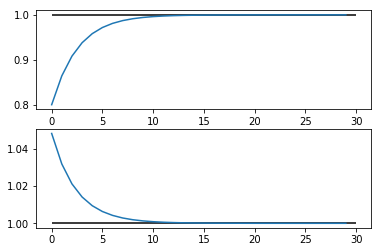

In [17]:
## plot optimal plans and check for convergence to steady state
fig, ax = plt.subplots(2,1)
ax[0].plot(range(T), kt[:-1])
ax[0].hlines(kss, 0, T)
ax[1].plot(range(T), ht)
ax[1].hlines(hss, 0, T)    